In [21]:
import pandas as pd
import os
import numpy as np
pd.options.display.max_columns = None

import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

from scipy import signal

In [22]:
#Select the columns to take
colstotake = ['Time_Val', 'Sensor Id',
       'Sensor1 Concentration', 'Sensor2 Concentration',
       'Sensor3 Concentration', 'Sensor4 Concentration',
       'Sensor5 Concentration', 'Sensor6 Concentration',
       'Sensor7 Concentration', 'Sensor8 Concentration',
       'Sensor9 Concentration', 'Sensor10 Concentration',
       'Sensor11 Concentration', 'Sensor12 Concentration',
       'Sensor13 Concentration', 'Sensor14 Concentration',
       'Sensor15 Concentration', 'Sensor16 Concentration',
       'Sensor17 Concentration', 'Sensor18 Concentration',
       'Sensor19 Concentration', 'Sensor20 Concentration', 'Leakage Status']

In [23]:
#Load all the data
dfdict = {}
for f in os.listdir(r'PATH WHERE THE DATA IS STORED'):
    df = pd.read_excel('PATH WHERE THE DATA IS STORED' + f)
    df = df[colstotake]
    df['Time_Val'] = pd.to_datetime(df['Time_Val']).dt.strftime(date_format = "%Y%m%d%H%M%S")
    dfdict[f.split('.')[0][-2:]] = df

In [24]:
dfdict.keys()

dict_keys(['2a', '2b', '2c', '2d', '2e', '2f', '2g', '2h', '2i', '2j', '2k', '2l', '2m', '2n', '2o', '2p', '2q', '2r'])

In [25]:
#Select the data
dataname = '2a'
data = dfdict[dataname].drop_duplicates().copy()

In [26]:
#Prepare the Data
desiredcolumnnames = ['Time_Val', 'Sensor_Id']+list(map(str, [210,337,342,330,123,134,157,173,193,195,215,238,250,280,291,374,381,385,364,370]))\
                            + ['Leakage_Status']
data.columns = desiredcolumnnames
data = data.sort_index(axis=1)
data = data.sort_values(by = 'Time_Val')

new_data = pd.DataFrame()
new_data['Time_Val'] = data['Time_Val']
new_data['Sensor_Id'] = data['Sensor_Id']
new_data['Value'] = data.apply(lambda x: x[str(x['Sensor_Id'])], axis = 1)

temp_data = new_data.pivot(index='Time_Val', columns='Sensor_Id', values='Value').reset_index().rename_axis(None, axis=1)
temp_data.columns = list(map(str, list(temp_data.columns)))
temp_data = temp_data.sort_index(axis = 1)

temp_data.loc[0, temp_data.iloc[0].isnull()] = data.drop(['Sensor_Id', 'Leakage_Status'], axis = 1).iloc[0][temp_data.iloc[0].isnull()].values
temp_data = pd.merge(temp_data, data[['Time_Val', 'Leakage_Status']].drop_duplicates(), on = 'Time_Val', how = 'inner')


data = temp_data.fillna(method='ffill').copy()

timestamp = data['Time_Val']
data.drop('Time_Val', axis = 1, inplace = True)
labelmap = {
    'No Leak' : 0,
    'Leak' : 1
}
data['Leakage_Status'] = data['Leakage_Status'].map(labelmap)
data = data.applymap(lambda x: round(x, 2))

In [27]:

#data.to_excel(r'D:\Books\Project\Draft1_fabien\leak-exp-day2\Exact\release2r.xlsx',index=False)

In [28]:
#Prepare the probabilities of events in individual columns
dictcolleak = {}
dictcolnotleak = {}
for col in data.columns:
    dictcolleak[col] = dict(data[data['Leakage_Status'] == 1][col].value_counts()/len(data[data['Leakage_Status'] == 1]))
    dictcolnotleak[col] = dict(data[data['Leakage_Status'] == 0][col].value_counts()/len(data[data['Leakage_Status'] == 0]))

In [29]:
def calculate_likelihood(x):
    try:
        likelihoodleak = np.prod([list(dictcolleak.values())[i][x[i]] for i in range(20)])
    except:
        likelihoodleak = 0
    try:
        likelihoodnotleak = np.prod([list(dictcolnotleak.values())[i][x[i]] for i in range(20)])
    except:
        likelihoodnotleak = 0
    return [likelihoodleak, likelihoodnotleak]

In [30]:
#Calculate the likelihood
temp = data.apply(calculate_likelihood, axis = 1)
likelihood_df = pd.DataFrame()
likelihood_df['time'] = timestamp
likelihood_df['Leak'] = np.asarray(temp.tolist())[:, 0]
likelihood_df['No Leak'] = np.asarray(temp.tolist())[:, 1]

In [31]:
#likelihood_df.to_csv(r'D:\Likelihood.csv')

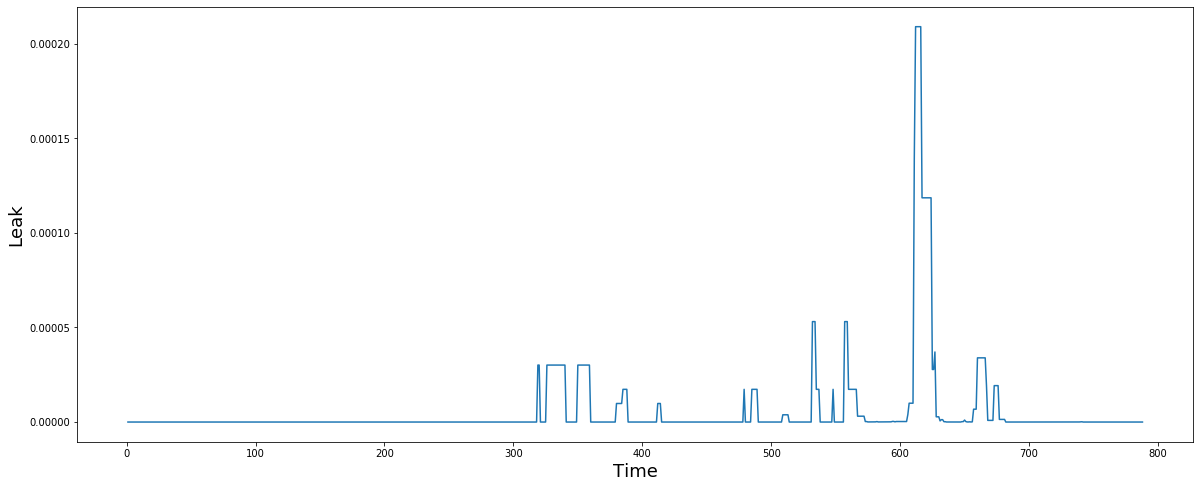

In [53]:
#Plot the likelihoods
plt.figure(figsize = (20,8))
x1 = []
x = likelihood_df['time'] = likelihood_df['time'].astype(str)
for i in range(0,len(x)):
    x1.append(i+1)
sns.lineplot(x = x1, y='Leak', data = likelihood_df)
plt.ylabel('Leak',fontsize = 18)
plt.xlabel('Time',fontsize = 18)
#plt.show()
plt.savefig(r'PLACE WHERE IMAGE MUST BE SAVED')

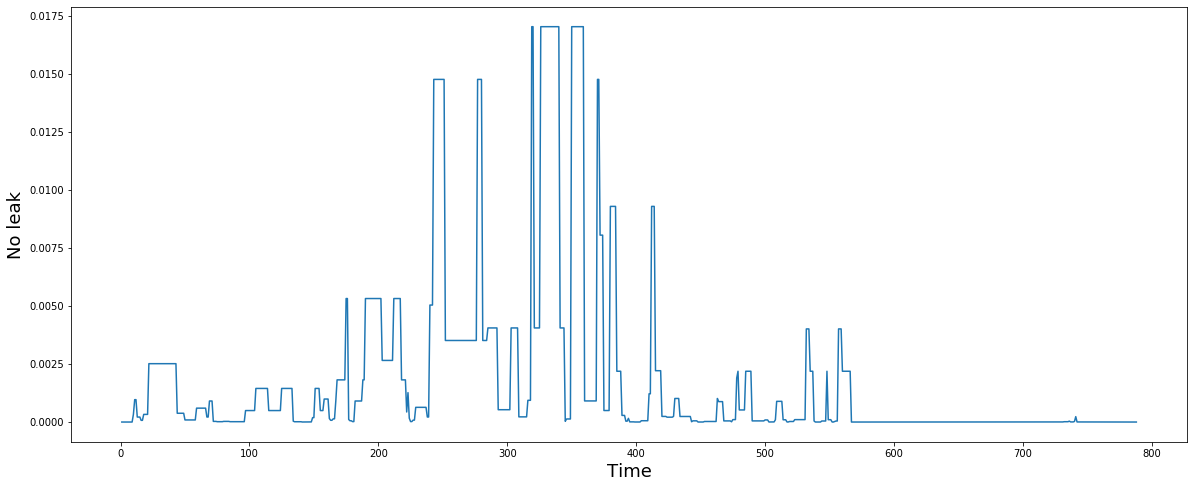

In [52]:
plt.figure(figsize = (20,8))
sns.lineplot(x = x1, y='No Leak', data = likelihood_df)
#plt.show()
plt.ylabel('No leak',fontsize = 18)
plt.xlabel('Time',fontsize = 18)
plt.savefig(r'PATH WHERE IMAGE MUST BE STORED')

In [33]:
from datetime import date, datetime, timedelta

In [34]:
likelihood_df_new = pd.DataFrame()
beg = int(likelihood_df['time'].values[0])
end = int(likelihood_df['time'].values[-1])
timelist = []
timelist.append(beg)
curr = beg
while(curr<end):
    curr = int((pd.to_datetime(curr, format = "%Y%m%d%H%M%S")+timedelta(seconds = 1)).strftime("%Y%m%d%H%M%S"))
    timelist.append(curr)
    
likelihood_df_new['time'] = timelist

likelihood_df['time'] = likelihood_df['time'].astype('int64')
likelihood_df_new = pd.merge(likelihood_df_new, likelihood_df, on = 'time', how = 'left')

likelihood_df_new = likelihood_df_new.fillna(method = 'ffill')
likelihood_df_new = likelihood_df_new[(likelihood_df_new['time'] >= ((beg//10)+1)*10) & (likelihood_df_new['time']<=(end//10)*10-1)]

In [35]:
# def autocorr(x, lag):
#     x['time_minutes'] = (x['time'].astype(float)//10)
#     timelist = x['time_minutes'].unique()
#     leaklist = []
#     noleaklist = []
    
#     for g in x.groupby('time_minutes'):
#         minute = g[0]
#         g = g[1]
#         leak = g['Leak'].values
#         noleak = g['No Leak'].values
#         leak = [np.corrcoef(np.array([leak[:-t], leak[t:]]))[0][1] for t in range(1, lag)]
#         noleak = [np.corrcoef(np.array([noleak[:-t], noleak[t:]]))[0][1] for t in range(1, lag)]
#         leaklist.append(leak)
#         noleaklist.append(noleak)
#     return timelist, leaklist, noleaklist

# #Calculate Autocorrelation
# lag = 5
# timelist, leaklist, noleaklist = autocorr(likelihood_df_new, lag)

# #Replace nans with zeros
# leaklist = [[0 if np.isnan(k) else k for k in i] for i in leaklist]
# noleaklist = [[0 if np.isnan(k) else k for k in i] for i in noleaklist]

# #Calculate the cosine similarity
# leak = cosine_similarity(leaklist).sum(axis = 0)
# noleak = cosine_similarity(noleaklist).sum(axis = 0)

In [36]:
def autocorrelation(a):
    a = np.array(a)
    corr = np.correlate(a,a,mode='full')/a.size
    corr = corr[corr.size//2:]
    return corr

def autocorr(x, lag):
    x['time_minutes'] = (x['time'].astype(float)//10)
    timelist = x['time_minutes'].unique()
    leaklist = []
    noleaklist = []
    
    for g in x.groupby('time_minutes'):
        minute = g[0]
        g = g[1]
        leak = g['Leak'].values
        noleak = g['No Leak'].values
        leak = autocorrelation(leak)
        noleak = autocorrelation(noleak)
        
#         _, leak = signal.welch(leak)
#         _, noleak = signal.welch(noleak)
        
        leaklist.append(leak)
        noleaklist.append(noleak)
    return timelist, leaklist, noleaklist

#Calculate Autocorrelation
lag = 5
timelist, leaklist, noleaklist = autocorr(likelihood_df_new, lag)

#Replace nans with zeros
leaklist = [[0 if np.isnan(k) else k for k in i] for i in leaklist]
noleaklist = [[0 if np.isnan(k) else k for k in i] for i in noleaklist]

#Calculate the cosine similarity
leak = cosine_similarity(leaklist).sum(axis = 0)
noleak = cosine_similarity(noleaklist).sum(axis = 0)

In [37]:
timelist.shape

(79,)

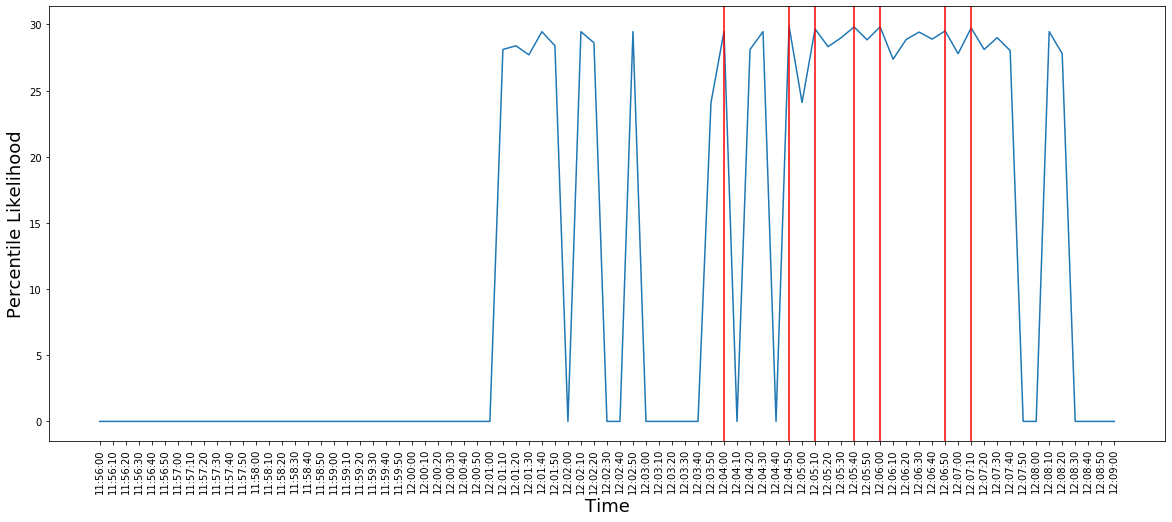

In [51]:
percentile = 90
y = leak.copy()
xtickstime = pd.to_datetime(pd.Series(timelist*10), format="%Y%m%d%H%M%S").dt.strftime(date_format = "%H:%M:%S").values
# xtickstime = list(map(str, (timelist*10)%1000000))
plt.figure(figsize = (20,8))
g = sns.lineplot(y = y, x = xtickstime)
xclist = list(np.where(y>np.percentile(y, percentile)))[0]
for xc in xclist:
    plt.axvline(xc, c = 'red')
g.set_xticklabels(labels =xtickstime,  rotation = 90)
#plt.show()
plt.xlabel('Time',fontsize = 18)
plt.ylabel('Percentile Likelihood',fontsize = 18)
plt.savefig(r'PATH WHERE IMAGE IS STORED')

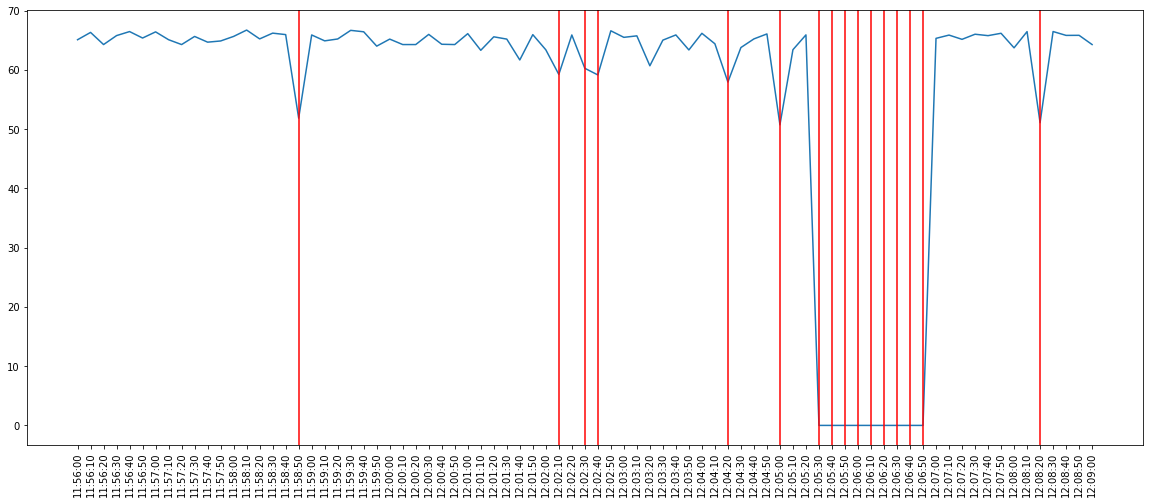

In [39]:
percentile = 20
y = noleak.copy()
xtickstime = pd.to_datetime(pd.Series(timelist*10), format="%Y%m%d%H%M%S").dt.strftime(date_format = "%H:%M:%S").values
# xtickstime = list(map(str, (timelist*10)%1000000))
plt.figure(figsize = (20,8))
g = sns.lineplot(y = y, x = xtickstime)
xclist = list(np.where(y<np.percentile(y, percentile)))[0]
for xc in xclist:
    plt.axvline(xc, c = 'red')
g.set_xticklabels(labels =xtickstime,  rotation = 90)
plt.show()